# **Tracking Active Cases to visualize how countries are faring against Covid-19**

This notebook uses data from COVID-19 Data Repository by CSSE at Johns Hopkins University  https://github.com/CSSEGISandData/COVID-19) to calculate Active Cases in each country and segment them on % Cases Active(Active Cases/Total Cases) and % Active Cases from Peak(Active Cases/Peak Active Cases).

The goal is to plot a trend of **% Cases Active** and **% Active Cases from Peak** for segmented countries.

**Packages Import**

Importing pandas for data manipulation and seaborn for data visualization. Also initiating a dictionary to import data for Confirmed cases, Active cases and Deaths.

In [1]:
import pandas as pd
import seaborn as sns

# Dictionary to store file links
files_url = {
                "Confirmed":"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
                "Recovered":"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv",
                "Deaths":"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
            }

**Defining Utility Function**

Defining a fucntion that accepts the file type, link and pivots the date columns to rows for creating a tidy dataset. The source file has Country, State in rows and Dates are stored as columns (wide data format). For handling data in an easier way, it is better to have each observation as rows.

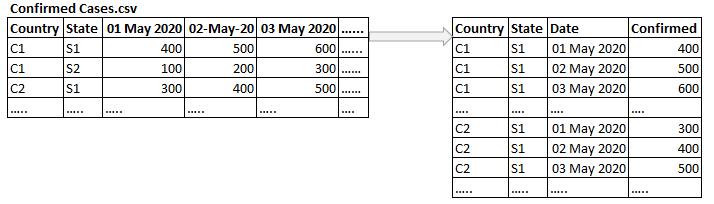


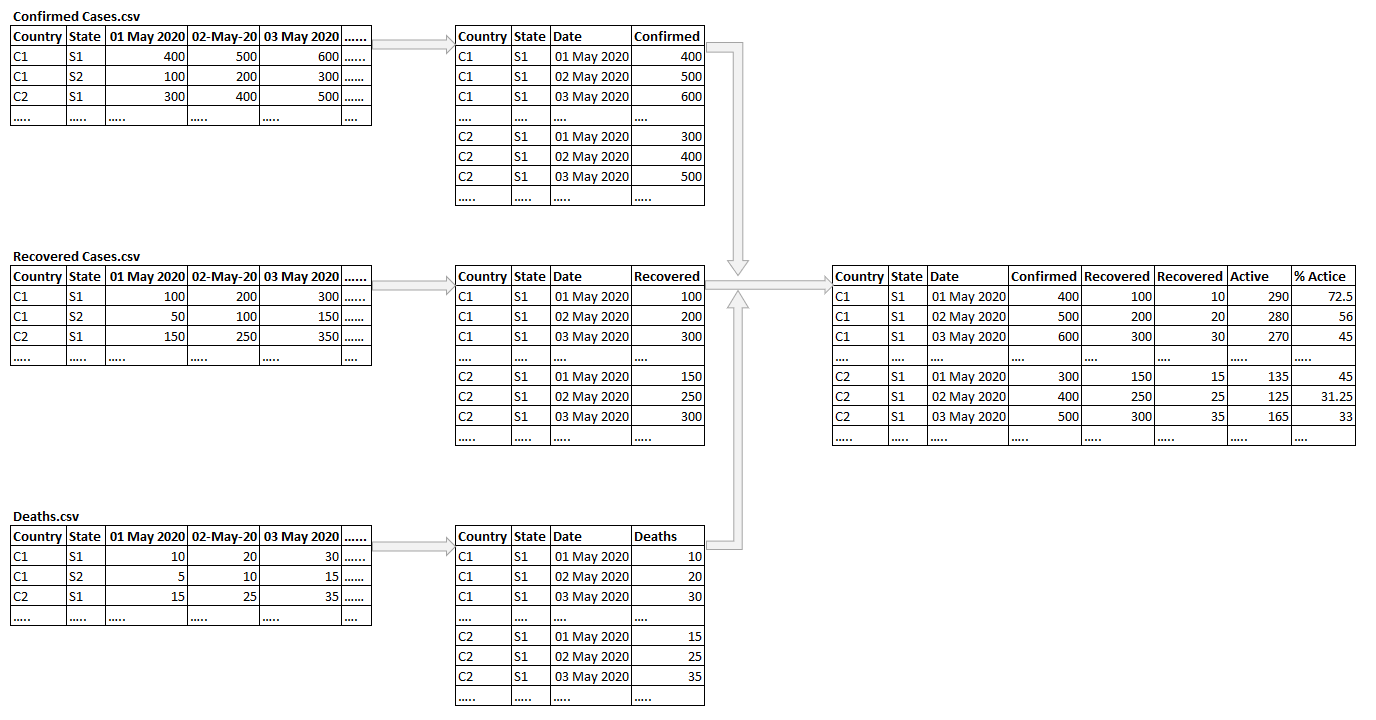

In [3]:
# Creating combined data frame with appended Confirmed, Recovered and Deaths data
covid19_data = pd.concat([get_data(file_type, path) for file_type, path in files_url.items()])
covid19_data = covid19_data.groupby(['Country','Date']).sum().sort_values(['Country','Date'])

# Calculating Active cases and % Cases Active
covid19_data['Active'] = covid19_data['Confirmed'] - (covid19_data['Deaths'] + covid19_data['Recovered'])
covid19_data['% Cases Active'] = covid19_data['Active']/covid19_data['Confirmed']*100

covid19_data.head()
covid19_data.tail()

Confirmed  Recovered  Deaths  Active  % Cases Active
Country  Date                                                            
Zimbabwe 2020-05-05       34.0        5.0     4.0    25.0       73.529412
         2020-05-06       34.0        5.0     4.0    25.0       73.529412
         2020-05-07       34.0        5.0     4.0    25.0       73.529412
         2020-05-08       34.0        9.0     4.0    21.0       61.764706
         2020-05-09       35.0        9.0     4.0    22.0       62.857143

**Segmenting Countries based of %Active Cases and %Active Cases from Peak**

country_map data frame is created to store maximun recorded active cases(i.e. peak active cases), current active cases and %current active cases.

Bins are defined on % Cases Active from Peak and % Active Cases to segment countries into different groups.


In [4]:
# Creating Data frame to segment countries based on % Current Cases Active and % Active Cases from peak
# Calculate max_active, current_active and current_active_pct 
country_map = covid19_data.groupby(['Country']).agg(max_active = ('Active', 'max'),
                                                    current_active = ('Active', 'last'),
                                                    current_active_pct = ('% Cases Active', 'last'))
# Calculate % Active cases from peak
country_map['active_from_peak_pct'] = country_map['current_active']/country_map['max_active']*100

# Defining bin limits and segmenting Countries 
bin_active_from_peak_pct = [-1, 25, 50, 75, 90, 99, 101]
bin_active_from_peak_pct_labels = ['< 25%', '25% - 50%', '50% - 70%', '75% - 90%', '90% - 99%', '100% (Active Cases Still Rising)']
country_map['Group % Cases Active From Peak'] = pd.cut(country_map['active_from_peak_pct'], bins=bin_active_from_peak_pct , labels=bin_active_from_peak_pct_labels)

bin_active_pct = [-1, 25, 50, 75, 90, 101]
bin_active_pct_labels = ['< 25%', '25% - 50%', '50% - 75%', '75% - 90%', '> 90%']
country_map['Group % Cases Active'] = pd.cut(country_map['current_active_pct'], bins=bin_active_pct, labels=bin_active_pct_labels)

country_map.head()
country_map.tail()

,max_active,current_active,current_active_pct,active_from_peak_pct,Group % Cases Active From Peak,Group % Cases Active
Country,,,,,,
West Bank and Gaza,275.0,145.0,38.666667,52.727273,50% - 70%,25% - 50%
Western Sahara,6.0,1.0,16.666667,16.666667,< 25%,< 25%
Yemen,26.0,26.0,76.470588,100.000000,100% (Active Cases Still Rising),75% - 90%
Zambia,133.0,133.0,52.777778,100.000000,100% (Active Cases Still Rising),50% - 75%
Zimbabwe,31.0,22.0,62.857143,70.967742,50% - 70%,50% - 75%


**Plotting charts for Active Cases**

By default 5 countries are plotted for each segment. Update max countries to plot to increase counts.

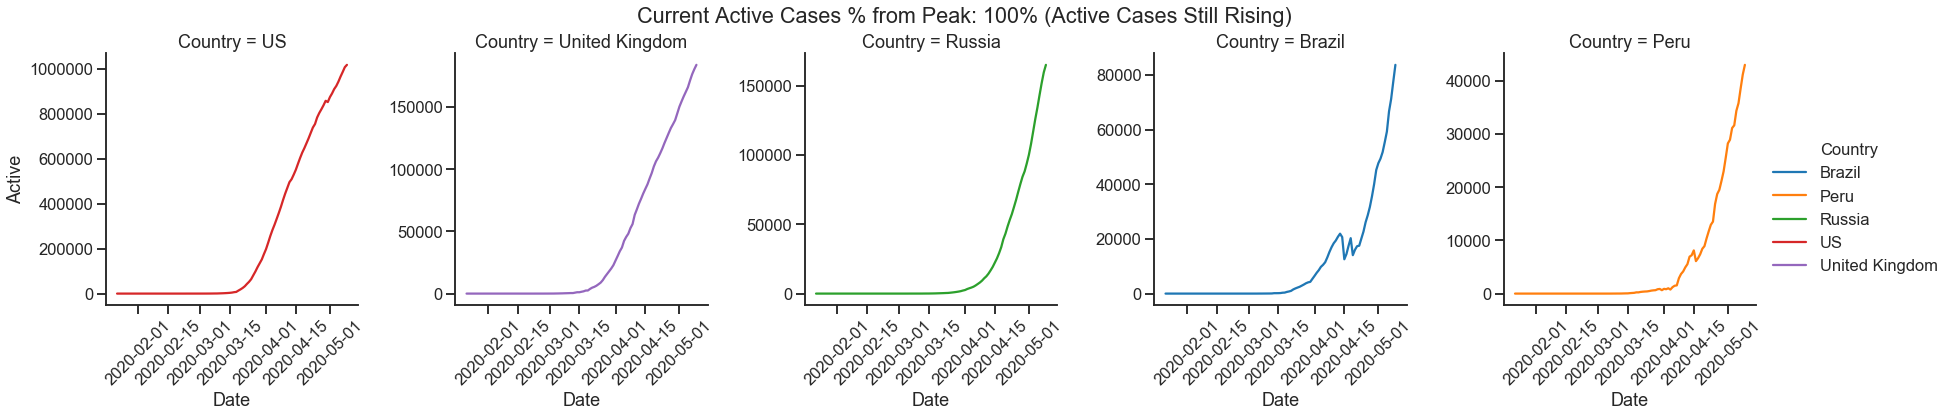

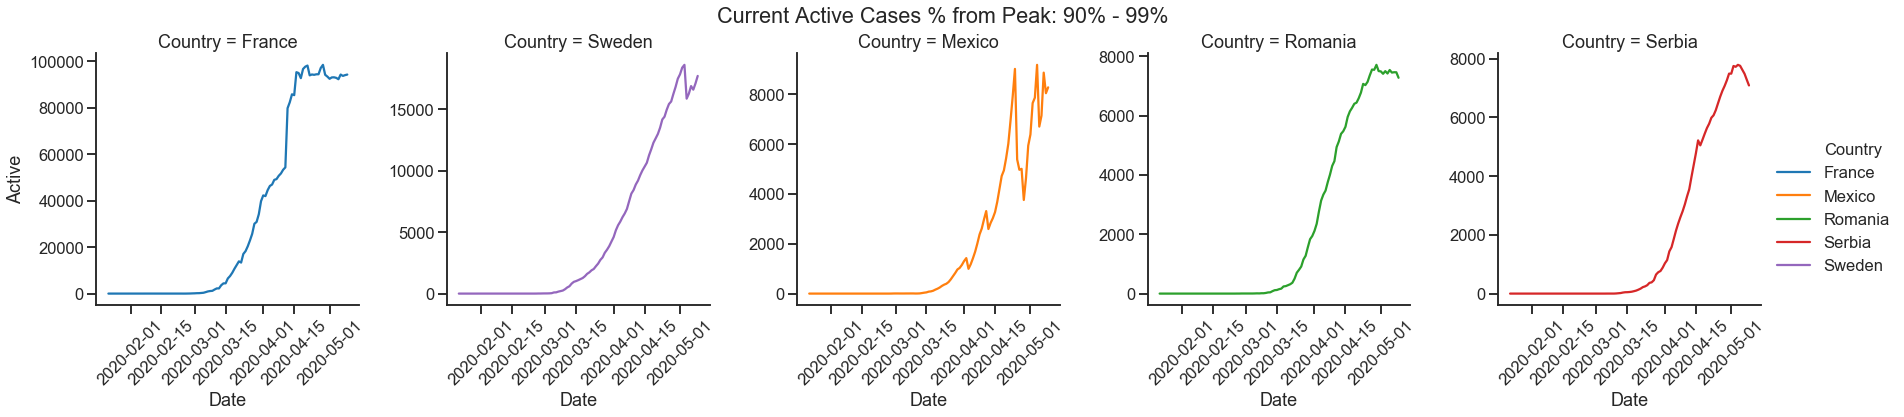

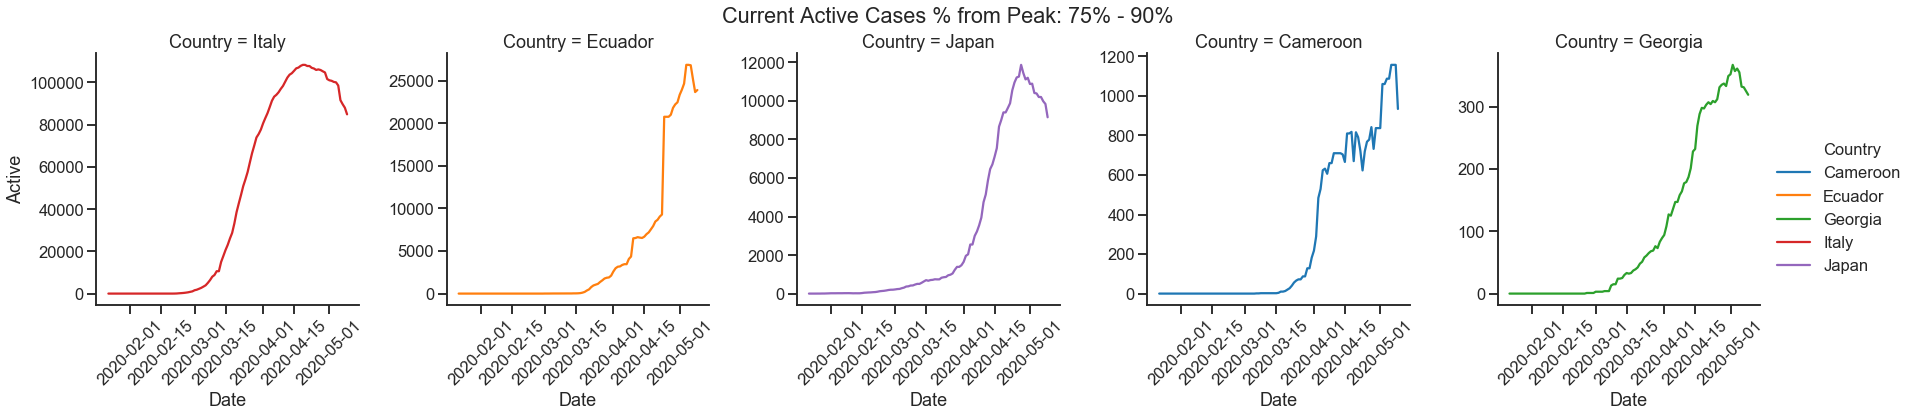

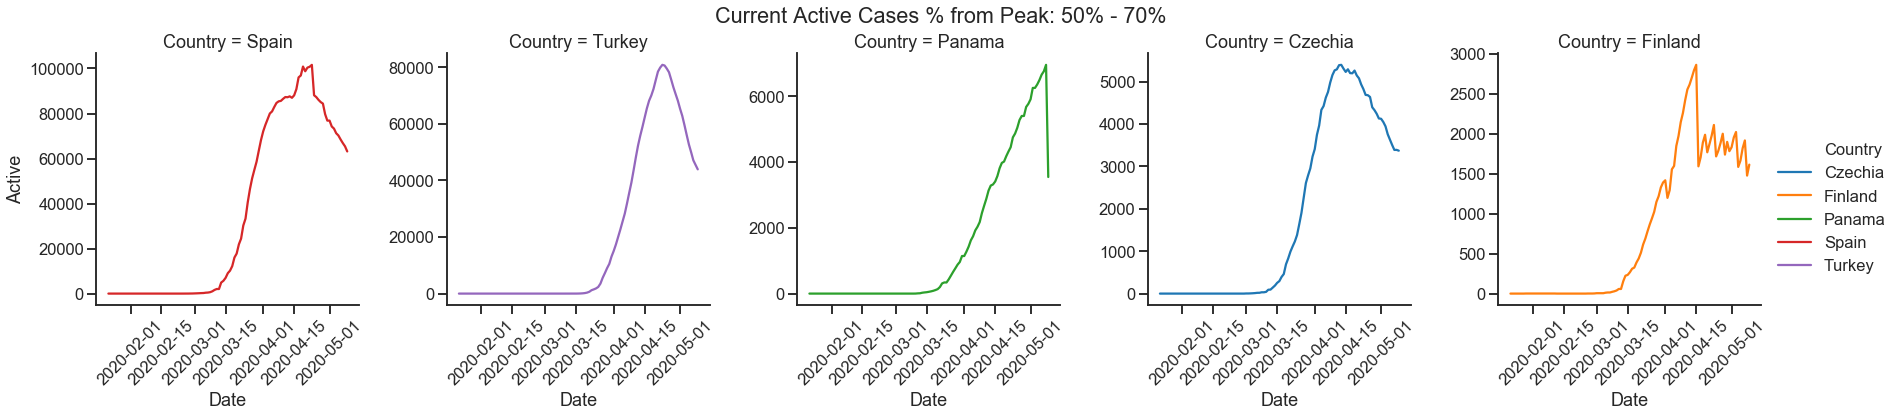

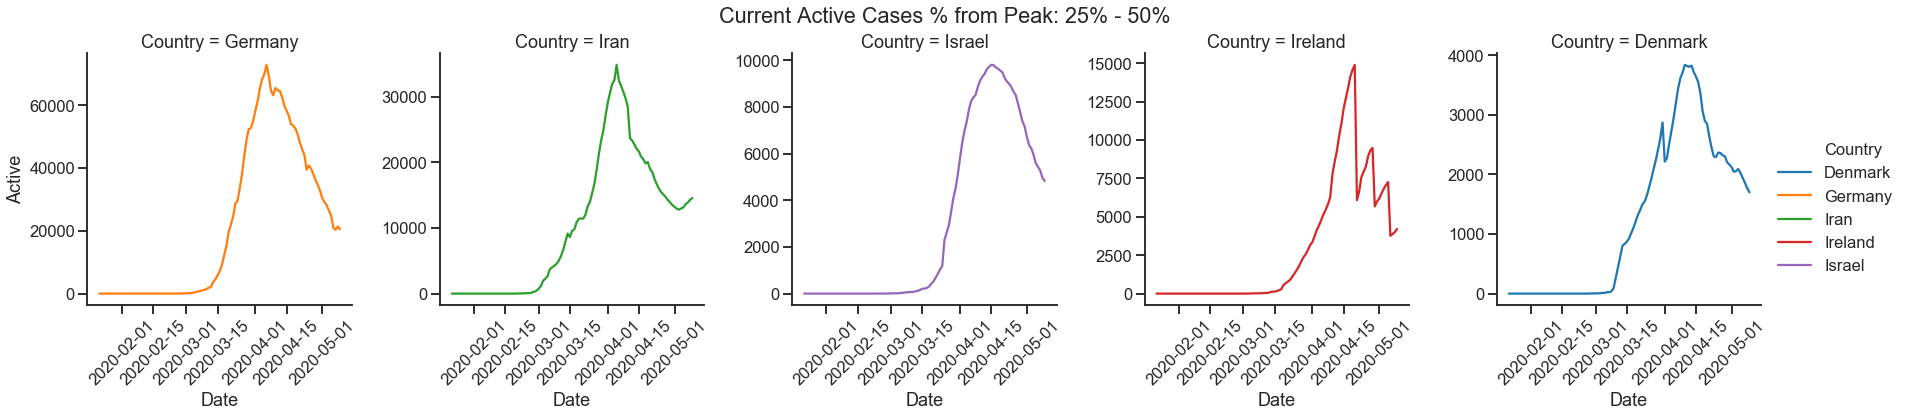

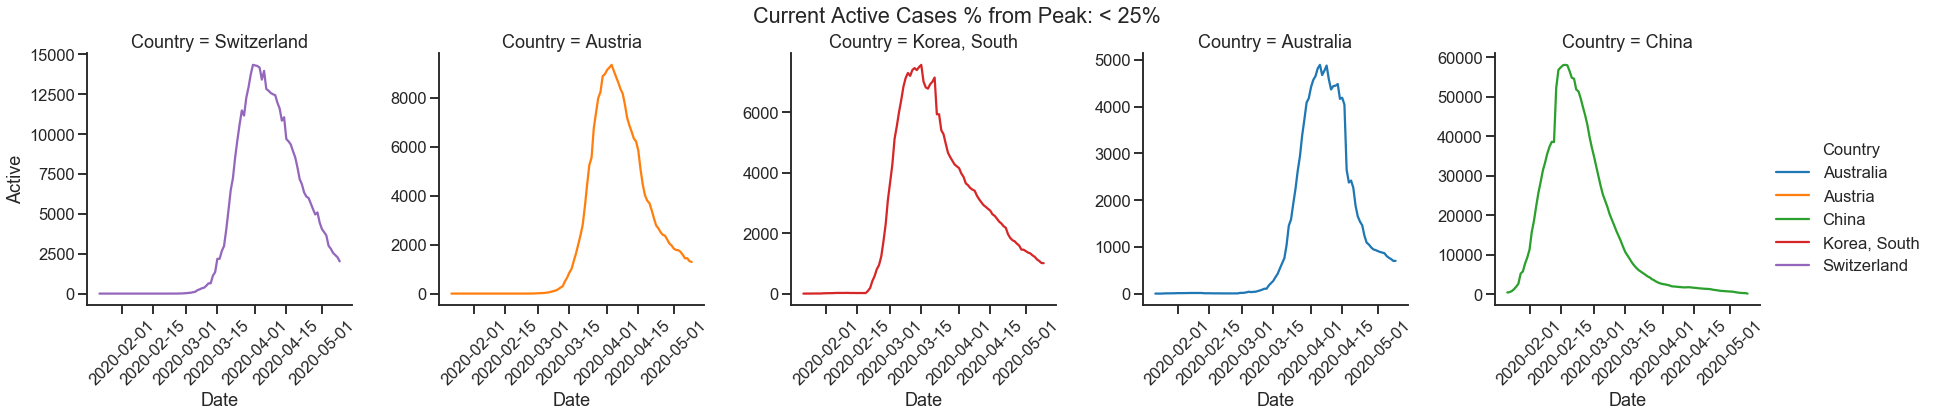

In [5]:
max_countries_to_plot = 5
sns.set_style('ticks')
sns.set_context('talk')


# Plotting Active Cases
for country_grp in reversed(bin_active_from_peak_pct_labels):
    list_country = country_map[country_map['Group % Cases Active From Peak']==country_grp].sort_values('current_active', ascending=False).index.unique()[:max_countries_to_plot]
    plot_df = covid19_data.loc[list_country].reset_index()
    g = sns.relplot(x='Date', y='Active', data=plot_df, col='Country', col_wrap=5, col_order=list_country, hue='Country', kind='line', facet_kws={'sharey':None})
    g.set_xticklabels(rotation=45)
    g.fig.suptitle("Current Active Cases % from Peak: "+country_grp, y=1.02)

**Plotting charts for % Active Cases**

By default 5 countries are plotted for each segment. Update max countries to plot to increase counts.

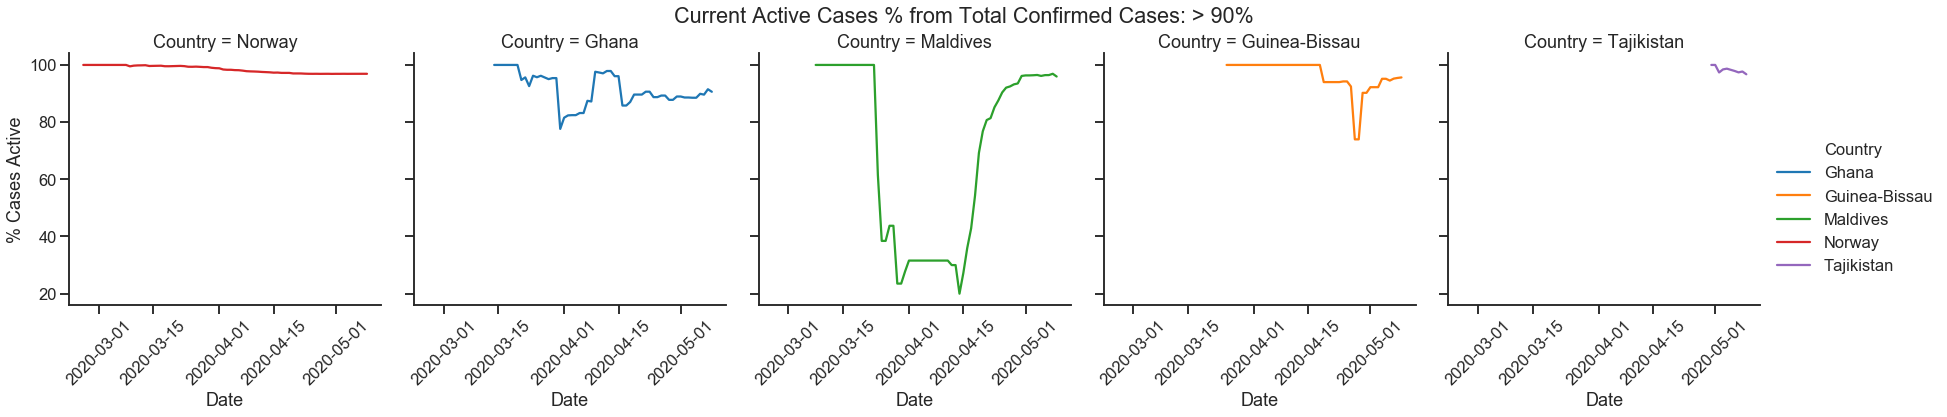

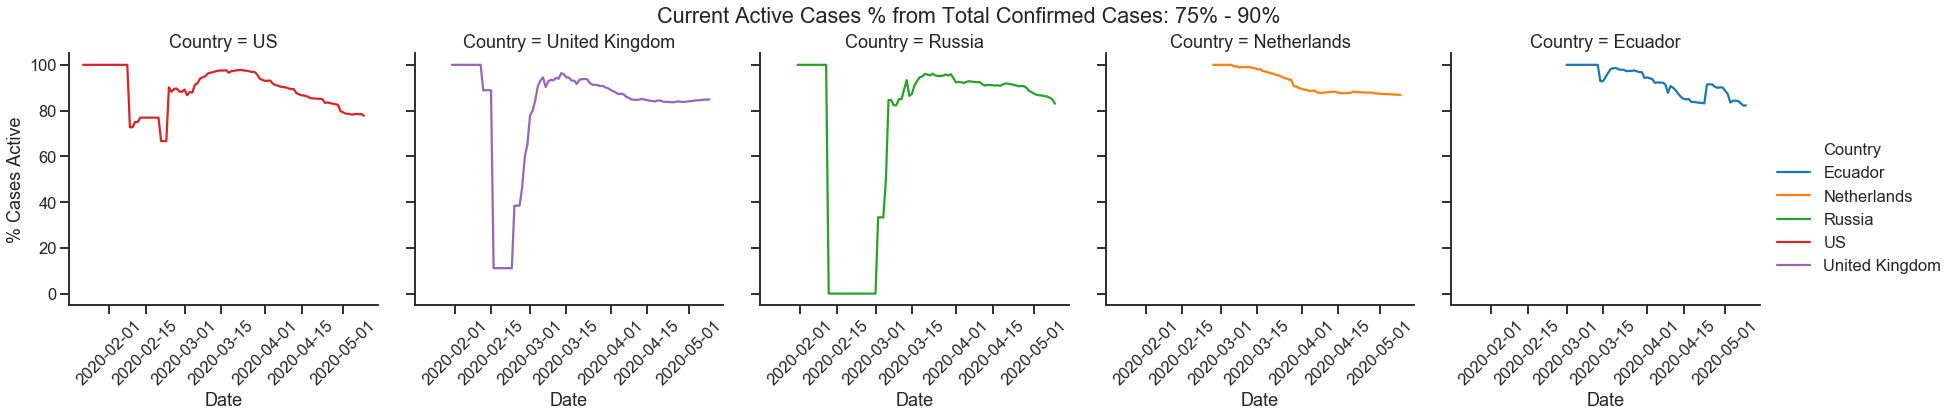

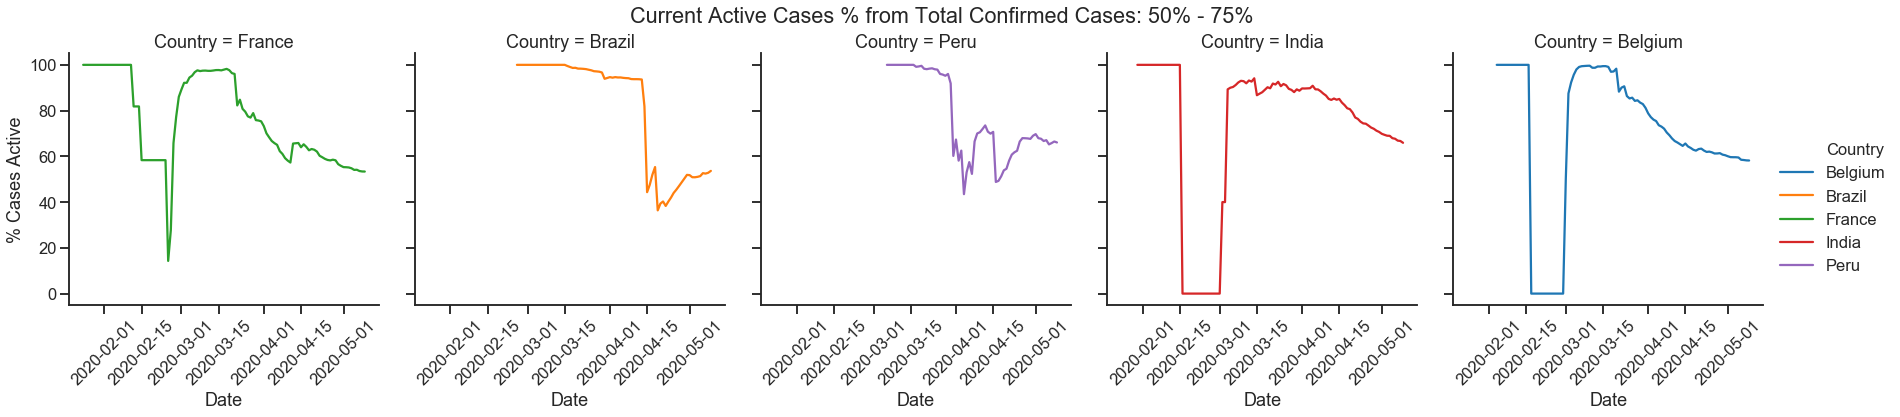

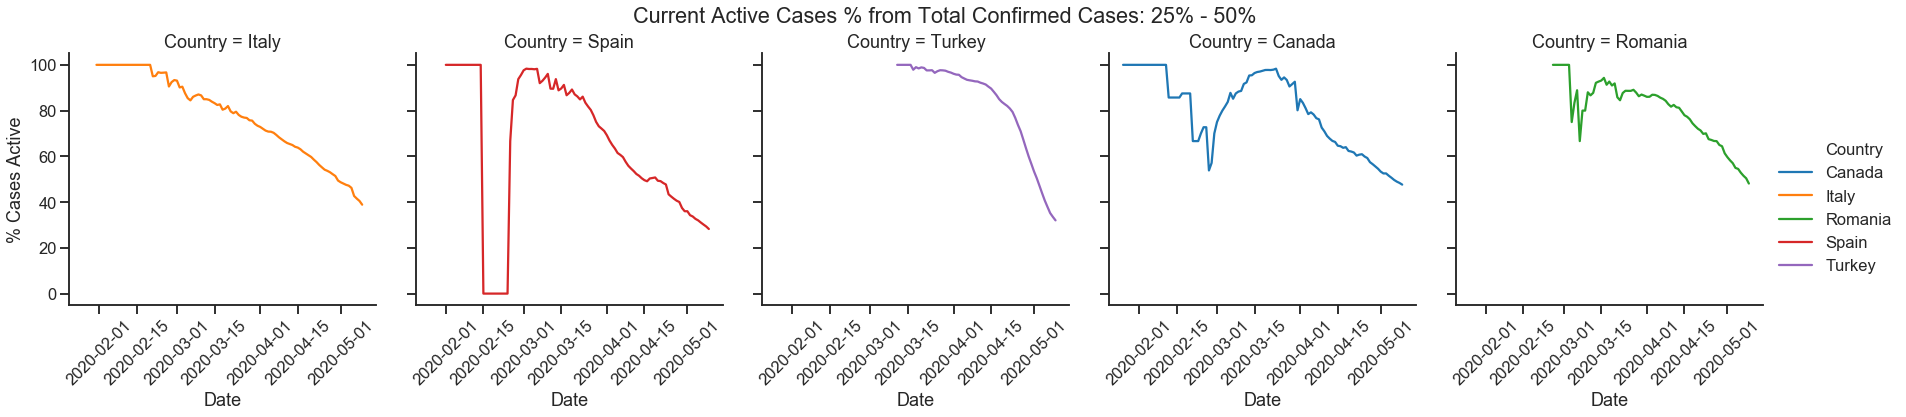

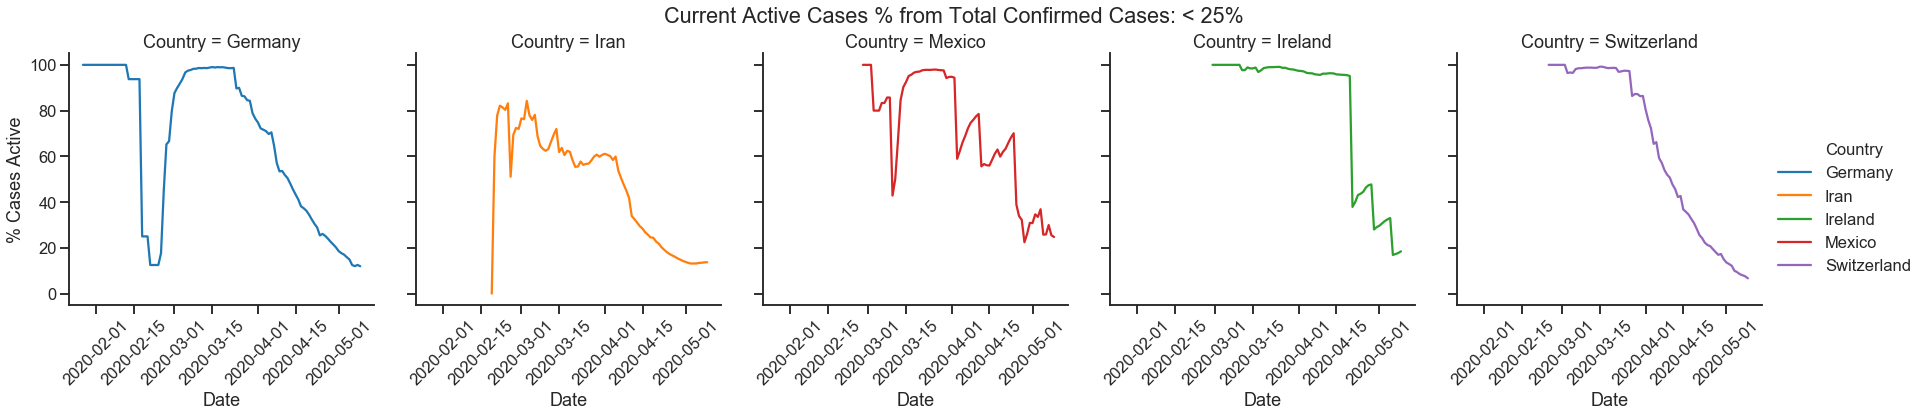

In [6]:
max_countries_to_plot = 5
sns.set_style('ticks')
sns.set_context('talk')


# Plotting % Active Cases of Total Confirmed Cases
for country_grp in reversed(bin_active_pct_labels):
    list_country = country_map[country_map['Group % Cases Active']==country_grp].sort_values('current_active', ascending=False).index.unique()[:max_countries_to_plot]
    plot_df = covid19_data.loc[list_country].reset_index()
    g = sns.relplot(x='Date', y='% Cases Active', data=plot_df, col='Country', col_wrap=5, col_order=list_country, hue='Country', kind='line')
    g.set_xticklabels(rotation=45)
    g.fig.suptitle("Current Active Cases % from Total Confirmed Cases: "+country_grp, y=1.02)
